# 데이터 전처리

## 목차
1. 결측치 처리
2. 이상치 처리
3. 수치형 데이터 스케일링
4. 범주형 데이터 인코딩
5. 차원 축소


## 1. 결측치 처리

### 개념
결측치는 데이터에서 값이 없는 부분입니다. 머신러닝 모델은 결측치를 처리할 수 없으므로 전처리가 필요합니다.

### 방법 1: 제거

In [ ]:
import pandas as pd
import numpy as np

# 데이터 생성
df = pd.DataFrame({
    'A': [1, 2, np.nan, 4],
    'B': [5, np.nan, 7, 8],
    'C': ['a', 'b', np.nan, 'a']
})

# 결측치 확인
print(df.isna().sum())

# 행 삭제
df_drop_rows = df.dropna()  # 결측치가 있는 행 제거
df_drop_cols = df.dropna(axis=1)  # 결측치가 있는 열 제거

A    1
B    1
C    0
dtype: int64


### 방법 2: 대체

In [ ]:
df = pd.DataFrame({
    'A': [1, 2, np.nan, 4],
    'B': [5, np.nan, 7, 8],
    'C': ['a', 'b', np.nan, 'a']
})

# 평균값으로 대체
df['A'] = df['A'].fillna(df['A'].mean())

# 중앙값으로 대체
df['B'] = df['B'].fillna(df['B'].median())

# 최빈값으로 대체 (범주형)
df['C'] = df['C'].fillna(df['C'].mode()[0])

### 방법 3: sklearn imputer

결측값(NaN) 을 다루기 위한 사이킷런(sklearn) 모듈

In [9]:
from sklearn.impute import SimpleImputer, KNNImputer

df = pd.DataFrame({
    'A': [1, 2, np.nan, 4],
    'B': [5, np.nan, 7, 8],
    'C': ['a', 'b', np.nan, 'a']
})

# Simple Imputer
imputer = SimpleImputer(strategy='mean')  # 'median': 중앙값, 'most_frequent': 최빈값
df_filled = imputer.fit_transform(df[['A', 'B']])
print(df_filled)

# KNN Imputer (고급)
knn_imputer = KNNImputer(n_neighbors=3)
df_knn = knn_imputer.fit_transform(df[['A', 'B']])
print(df_knn)

[[1.         5.        ]
 [2.         6.66666667]
 [2.33333333 7.        ]
 [4.         8.        ]]
[[1.  5. ]
 [2.  6.5]
 [2.5 7. ]
 [4.  8. ]]


---

## 2. 이상치(Outlier) 처리

### 방법 1: IQR 방법

In [22]:
import matplotlib.pyplot as plt

# 데이터 생성
data = np.random.normal(loc=50, scale=10, size=100)
data = np.append(data, [-50, 150, 200])  # 이상치 추가

# IQR 계산
Q1 = np.percentile(data, 25)
Q3 = np.percentile(data, 75)
IQR = Q3 - Q1

# 이상치 경계
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 이상치 탐지
outliers = data[(data < lower_bound) | (data > upper_bound)]
print(f"이상치: {outliers}")

# 이상치 제거
data_clean = data[(data >= lower_bound) & (data <= upper_bound)]

이상치: [ 22.92433724 -50.         150.         200.        ]


### 방법 2: Z-Score 방법

Z-score: 데이터 값이 평균에서 몇 개의 표준편차만큼 떨어져 있는지를 나타내는 지표

$z = \frac{x-\mu}{\sigma}$

In [17]:
from scipy import stats

mean = np.mean(data)
std = np.std(data, ddof=1) # 표본표준편차

# Z-Score 계산
z_scores = (data - mean) / std

# 임계값 3 이상을 이상치로 판단
threshold = 3
outliers_z = data[(z_scores > threshold) | (z_scores < -threshold)]
print(f"Z-Score 이상치: {outliers_z}")

# 이상치 제거
data_clean_z = data[z_scores <= threshold]

Z-Score 이상치: [150. 200.]


### 방법 3: 도메인 지식 기반

In [ ]:
# 예: 나이 데이터의 경우
ages = [25, 30, 35, 200, 28, -5, 40]  # 비현실적인 값들

# 도메인 지식으로 이상치 탐지
valid_ages = [age for age in ages if 0 <= age <= 120]
print(f"유효한 나이: {valid_ages}")

---

## 3. 수치형 데이터 스케일링

### 정규화 (Min-Max Scaling)

$x' = \frac{x-x_{min}}{x_{max}-x_{min}}$

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# 데이터프레임 생성
df = pd.DataFrame({"value": [1, 2, 3, 4, 5, 6]})

# Min-Max 스케일링
scaler = MinMaxScaler()
df["value_scaled"] = scaler.fit_transform(df[["value"]])
print(df)

# 수동 계산
# (값 - 최솟값) / (최댓값 - 최솟값)

   value  value_scaled
0      1           0.0
1      2           0.2
2      3           0.4
3      4           0.6
4      5           0.8
5      6           1.0


### 표준화 (Standardization)

$z = \frac{x-\mu}{\sigma}$

In [33]:
from sklearn.preprocessing import StandardScaler

# 데이터프레임 생성
df = pd.DataFrame({"value": [1, 2, 3, 4, 5, 6]})

# 표준화 (평균=0, 표준편차=1)
scaler = StandardScaler()
df["value_scaled"] = scaler.fit_transform(df[["value"]])
print(df)

# 수동 계산
# (값 - 평균) / 표준편차

   value  value_scaled
0      1      -1.46385
1      2      -0.87831
2      3      -0.29277
3      4       0.29277
4      5       0.87831
5      6       1.46385


- **정규화**: 데이터가 균등분포, 특정 범위 필요시
- **표준화**: 데이터가 정규분포, 이상치에 덜 민감

---

## 4. 범주형 데이터 인코딩

### Label Encoding

범주형 값을 사전식(알파벳/문자열) 오름차순으로 정렬한 뒤, 0부터 차례대로 번호 추가

In [ ]:
from sklearn.preprocessing import LabelEncoder

# 데이터프레임 생성
df = pd.DataFrame({'grade': ['A', 'D', 'B', 'C', 'F', 'B', 'A']})

# Label Encoding
encoder = LabelEncoder()
education_encoded = encoder.fit_transform(df['grade'])
print(f'Label Encoding: {education_encoded}')

Label Encoding: [0 3 1 2 4 1 0]


### One-Hot Encoding

In [46]:
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

# 순서가 없는 범주형 데이터
colors_df = pd.DataFrame({'color': ['red', 'blue', 'green', 'red']})

# sklearn 방법
encoder = OneHotEncoder(drop='first', sparse_output=False)
colors_encoded = encoder.fit_transform(colors_df)
colors_encoded_df = pd.DataFrame(colors_encoded, columns=encoder.get_feature_names_out())
print(f'One-Hot Encoding: \n {colors_encoded_df}')

One-Hot Encoding: 
    color_green  color_red
0          0.0        1.0
1          0.0        0.0
2          1.0        0.0
3          0.0        1.0


## 5. 피처 선택 (Feature Selection)

데이터에 여러 변수(피처)가 존재할 때, 중요한 변수만 뽑아내는 과정

### SelectKBest
타깃과 가장 관련성이 높은 상위 K개의 피처를 자동으로 선택해주는 방법

각 변수와 타겟간의 관계를 통계적 방법(점수 함수)로 판단하여 상위 K개만 남긴다.

원래 데이터 shape: (150, 4)
선택된 데이터 shape: (150, 2)
선택된 피처 인덱스: [False False  True  True]


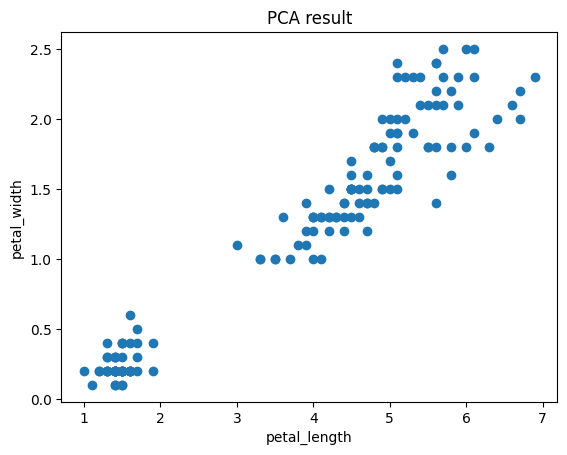

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, f_classif

df = sns.load_dataset('iris')
X = df.drop('species', axis=1)
y = df['species']

# SelectKBest: 상위 2개 피처 선택
selector = SelectKBest(score_func=f_classif, k=2)
X_kbest = selector.fit_transform(X, y)

print("원래 데이터 shape:", X.shape)   # (150, 4)
print("선택된 데이터 shape:", X_kbest.shape)  # (150, 2)

# 어떤 피처가 선택됐는지 확인
mask = selector.get_support()
print("선택된 피처 인덱스:", mask)

X_kbest = pd.DataFrame(X_kbest, columns=X.columns[mask])

# 시각화
plt.scatter(X_kbest.iloc[:, 0], X_kbest.iloc[:, 1])
plt.xlabel(X_kbest.columns[0])
plt.ylabel(X_kbest.columns[1])
plt.title('SelectKBest result')
plt.show()

### PCA (주성분 분석)

데이터에 있는 여러 변수들을 새롭게 조합해서, 데이터의 정보는 최대한 보존하면서 차원 수를 줄여주는 방법

1. 원래 변수들을 선형 결합해서 **새로운 축(주성분, Principal Component)**을 만든다.

2. 이때, 데이터 분산(정보량)이 가장 큰 방향을 첫 번째 주성분으로 잡는다.

3. 두 번째 주성분은 첫 번째와 직교(90도)하면서, 남은 분산을 최대한 설명하는 방향으로 잡는다.

4. 이런 식으로 여러 개의 주성분을 찾고, 원하는 개수(K개)의 주성분만 남겨서 데이터를 축소한다.

원래 shape: (150, 4)
PCA shape: (150, 2)
설명 분산 비율: [0.92461872 0.05306648]
누적 설명 분산: 0.978
pca.components_: 
 [[ 0.36138659 -0.08452251  0.85667061  0.3582892 ]
 [ 0.65658877  0.73016143 -0.17337266 -0.07548102]]


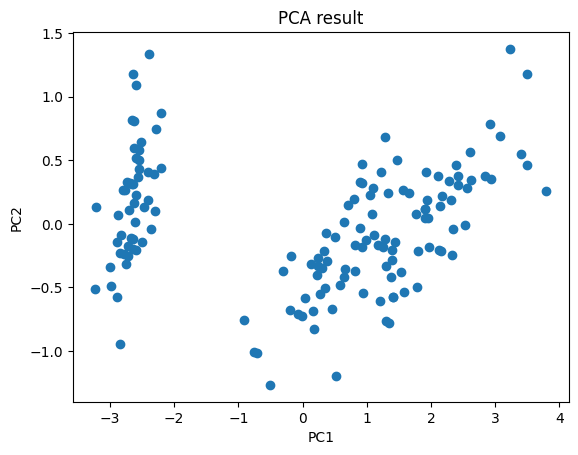

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
df = sns.load_dataset('iris')
X = df.drop('species', axis=1)

# PCA 적용
pca = PCA(n_components=2)  # 2차원으로 축소
X_pca = pca.fit_transform(X)

print("원래 shape:", X.shape)   # (150, 4)
print("PCA shape:", X_pca.shape)  # (150, 2)

# 설명 분산 비율
print(f"설명 분산 비율: {pca.explained_variance_ratio_}")
print(f"누적 설명 분산: {pca.explained_variance_ratio_.sum():.3f}")

# 주성분 벡터
print(f'pca.components_: \n {pca.components_}')
# PC1 = 0.361 × (특징1) − 0.085 × (특징2) + 0.857 × (특징3) + 0.358 × (특징4)
# PC2 = 0.657 × (특징1) + 0.730 × (특징2) − 0.173 × (특징3) − 0.075 × (특징4)

# 시각화
plt.scatter(X_pca[:, 0], X_pca[:, 1])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA result')
plt.show()

### 적절한 차원 수 선택

In [53]:
# 설명 분산 비율로 차원 수 결정
pca_full = PCA()
pca_full.fit(X)

# 95% 분산을 설명하는 차원 수 찾기
cumsum = np.cumsum(pca_full.explained_variance_ratio_)
n_components = np.argmax(cumsum >= 0.95) + 1
print(f"95% 분산 설명 차원 수: {n_components}")

95% 분산 설명 차원 수: 2
